# Ref: Kernels


https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields

https://www.kaggle.com/artgor/nn-baseline

https://www.kaggle.com/ogrellier/user-level-lightgbm-lb-1-4480

https://www.kaggle.com/dimitreoliveira/deep-learning-keras-ga-revenue-prediction


# setup and import

In [2]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder

path = '../data/'
print(os.listdir(path))

['test_adj.csv', 'test_dropped.csv', 'sample_submission.csv', 'train_dropped.csv', 'user_test.csv', 'train_orig.csv', 'test_parsed.csv', 'user_test_n.csv', 'train_parsed.csv', 'train_adj.csv', 'test_orig.csv', 'user_train.csv', 'user_train_n.csv']


# Parse data

In [2]:
def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, 
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df

In [5]:
%%time
df_train = load_df(path + 'train_orig.csv')

CPU times: user 1min 47s, sys: 3.06 s, total: 1min 50s
Wall time: 1min 50s


In [6]:
%%time
df_train.to_csv(path + 'train_parsed.csv')

CPU times: user 21 s, sys: 516 ms, total: 21.6 s
Wall time: 22.7 s


In [3]:
%%time
df_test = load_df(path + 'test_orig.csv')

CPU times: user 1min 35s, sys: 2.75 s, total: 1min 38s
Wall time: 1min 37s


In [4]:
%%time
df_test.to_csv(path + 'test_parsed.csv')

CPU times: user 18.9 s, sys: 492 ms, total: 19.4 s
Wall time: 19.7 s


# drop columns

In [17]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder

path = '../data/'
print(os.listdir(path))

['test_adj.csv', 'test_dropped.csv', 'sample_submission.csv', 'train_dropped.csv', 'user_test.csv', 'train_orig.csv', 'test_parsed.csv', 'user_test_n.csv', 'train_parsed.csv', 'train_adj.csv', 'test_orig.csv', 'user_train.csv', 'user_train_n.csv']


In [18]:
%%time
df_train = pd.read_csv(path +'train_parsed.csv', index_col = 0, dtype={'fullVisitorId': 'str'})
df_test = pd.read_csv(path +'test_parsed.csv', index_col = 0, dtype={'fullVisitorId': 'str'})

<string>:2: DtypeWarning: Columns (50) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 21.9 s, sys: 752 ms, total: 22.7 s
Wall time: 22.3 s


## Align #of colums

In [19]:
%%time
df_train, df_test = df_train.align(df_test, join='outer', axis=1)

df_train.replace(to_replace=np.nan, value=0, inplace=True)
df_test.replace(to_replace=np.nan, value=0, inplace=True)



CPU times: user 6.3 s, sys: 811 ms, total: 7.11 s
Wall time: 6.49 s


## determine columns to drop

In [35]:
%%time

cols_not_unique = [col for col in df_train.columns if df_train[col].nunique() < 2]

cols_null_ratio_high = [col for col in df_train.columns if sum(df_train[col].isnull()) / len(df_train) >= 0.6]

cols_not_much_var = []
df_num = df_train.select_dtypes(include=[np.number])
df_var = df_num.var()
for x in df_num:
    if df_var[x] <= 30:
        cols_not_much_var.append(x)



CPU times: user 5.02 s, sys: 47.7 ms, total: 5.07 s
Wall time: 4.75 s


In [36]:
no_touch = ['fullVisitorId','transactionRevenue']

del_cols = []
del_cols.extend(cols_not_unique)
del_cols.extend(cols_null_ratio_high)
del_cols.extend(cols_not_much_var)
del_cols = list(set(del_cols))

del_cols = [x for x in del_cols if x not in no_touch]

del_cols

['adwordsClickInfo.criteriaParameters',
 'mobileDeviceInfo',
 'adwordsClickInfo.isVideoAd',
 'longitude',
 'mobileDeviceModel',
 'latitude',
 'socialEngagementType',
 'bounces',
 'screenColors',
 'mobileDeviceBranding',
 'flashVersion',
 'operatingSystemVersion',
 'language',
 'browserSize',
 'networkLocation',
 'mobileInputSelector',
 'browserVersion',
 'cityId',
 'adwordsClickInfo.page',
 'newVisits',
 'visits',
 'mobileDeviceMarketingName',
 'screenResolution']

In [37]:
df_train.drop(del_cols, axis=1, inplace=True)
df_test.drop(del_cols, axis=1, inplace=True)

In [38]:
%%time
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

df_train.to_csv(path + 'train_dropped.csv')
df_test.to_csv(path + 'test_dropped.csv')

CPU times: user 26.4 s, sys: 1.02 s, total: 27.4 s
Wall time: 27.5 s


In [45]:
print(df_train.shape)
print(df_test.shape)

(903653, 32)
(804684, 32)


# Edit columns

In [64]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder

path = '../data/'
print(os.listdir(path))

['test_adj.csv', 'test_dropped.csv', 'sample_submission.csv', 'train_dropped.csv', 'user_test.csv', 'train_orig.csv', 'test_parsed.csv', 'user_test_n.csv', 'train_parsed.csv', 'train_adj.csv', 'test_orig.csv', 'user_train.csv', 'user_train_n.csv']


In [82]:
%%time
df_train = pd.read_csv(path +'train_dropped.csv', index_col = 0, dtype={'fullVisitorId': 'str'})
df_test = pd.read_csv(path +'test_dropped.csv', index_col = 0, dtype={'fullVisitorId': 'str'})

<string>:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 9.58 s, sys: 268 ms, total: 9.85 s
Wall time: 9.43 s


## only for train dataset

In [83]:
# to float and log
df_train['transactionRevenue'] = df_train['transactionRevenue'].astype(float)
df_train['transactionRevenue'] = np.log1p(df_train['transactionRevenue'].fillna(0))


## to both train and test datasets

In [84]:
print(df_train.shape)
print(df_test.shape)
print(df_train.columns)

(903653, 32)
(804684, 32)
Index(['adContent', 'adwordsClickInfo.adNetworkType', 'adwordsClickInfo.gclId',
       'adwordsClickInfo.slot', 'browser', 'campaign', 'campaignCode',
       'channelGrouping', 'city', 'continent', 'country', 'date',
       'deviceCategory', 'fullVisitorId', 'hits', 'isMobile', 'isTrueDirect',
       'keyword', 'medium', 'metro', 'networkDomain', 'operatingSystem',
       'pageviews', 'referralPath', 'region', 'sessionId', 'source',
       'subContinent', 'transactionRevenue', 'visitId', 'visitNumber',
       'visitStartTime'],
      dtype='object')


### delete columns

In [85]:
del_cols = [
            'adContent', 'adwordsClickInfo.adNetworkType', 'adwordsClickInfo.gclId',
            'adwordsClickInfo.slot', 'campaignCode','city', 'country',
            'keyword', 'medium', 'metro', 'networkDomain', 
            'referralPath', 'region', 'sessionId', 'source',
            'subContinent', 'visitId', 'visitNumber','visitStartTime'
            ]


In [86]:
%%time

for x in del_cols:
    df_train.drop(x, axis=1, inplace=True)
    df_test.drop(x, axis=1, inplace=True)



CPU times: user 3.11 s, sys: 973 ms, total: 4.08 s
Wall time: 4.08 s


### analyze date

In [87]:
%%time
def dateCol(df):

    df['date'] = pd.to_datetime(df['date'].apply(lambda x: str(x)[:4] + '-' + str(x)[4:6] + '-' + str(x)[6:]))
    df['month'] = df['date'].dt.month
    df['weekday'] = df['date'].dt.weekday
    df['weekend'] = df['weekday'].apply(lambda x: 1 if x>=5 else 0)
    
    return df

df_train = dateCol(df_train)
df_test = dateCol(df_test)

CPU times: user 3.35 s, sys: 24 ms, total: 3.37 s
Wall time: 2.64 s


### access count column

In [88]:
%%time
def userCount(df):
    df['dummy'] = 1
    df['cnt_per_day'] = df[['fullVisitorId','date', 'dummy']].groupby(['fullVisitorId','date'])['dummy'].transform('sum')

    df.drop('dummy', axis=1, inplace=True)
    return df

df_train = userCount(df_train)
df_test = userCount(df_test)

CPU times: user 3.99 s, sys: 96.8 ms, total: 4.08 s
Wall time: 3.26 s


### One-Hot columns

In [90]:
no_touch = ['fullVisitorId','transactionRevenue']
onehot_cols = [x for x in df_train.columns if df_train[x].dtypes == 'object']
onehot_cols = [x for x in onehot_cols if df_train[x].nunique() <= 10 and df_train[x].nunique() >= 3]
onehot_cols = [x for x in onehot_cols if x not in no_touch]

onehot_cols

['campaign', 'channelGrouping', 'continent', 'deviceCategory']

In [91]:
%%time

def oneHot(df,col):
    dum = pd.get_dummies(df[col], drop_first = True)
    df = pd.concat((df, dum),axis = 1)
    df = df.drop(col,axis = 1)
    return df

for x in onehot_cols:
    df_train = oneHot(df_train,x)
    df_test = oneHot(df_test,x)


CPU times: user 5.5 s, sys: 887 ms, total: 6.38 s
Wall time: 3.42 s


### category string to numbers

In [95]:
no_touch = ['fullVisitorId','transactionRevenue']
cat_cols = [x for x in df_train.columns if df_train[x].dtypes == 'object' or df_train[x].dtypes == 'bool']
cat_cols = [x for x in cat_cols if df_train[x].nunique() <= 100]
cat_cols = [x for x in cat_cols if x not in no_touch]

cat_cols

['browser', 'isMobile', 'isTrueDirect', 'operatingSystem']

In [96]:
%%time

for col in cat_cols:
    lbl = LabelEncoder()
    lbl.fit(list(df_train[col].values.astype('str')) + list(df_test[col].values.astype('str')))
    df_train[col] = lbl.transform(list(df_train[col].values.astype('str')))
    df_test[col] = lbl.transform(list(df_test[col].values.astype('str')))


CPU times: user 16.4 s, sys: 1.24 s, total: 17.7 s
Wall time: 14 s


In [97]:
no_touch = ['fullVisitorId','transactionRevenue','date']
l_float = [x for x in df_train.columns if x not in no_touch]
l_float

['browser',
 'hits',
 'isMobile',
 'isTrueDirect',
 'operatingSystem',
 'pageviews',
 'month',
 'weekday',
 'weekend',
 'cnt_per_day',
 'AW - Accessories',
 'AW - Apparel',
 'AW - Dynamic Search Ads Whole Site',
 'AW - Electronics',
 'All Products',
 'Data Share',
 'Data Share Promo',
 'Retail (DO NOT EDIT owners nophakun and tianyu)',
 'test-liyuhz',
 'Affiliates',
 'Direct',
 'Display',
 'Organic Search',
 'Paid Search',
 'Referral',
 'Social',
 'Africa',
 'Americas',
 'Asia',
 'Europe',
 'Oceania',
 'mobile',
 'tablet']

In [98]:
%%time

df_train[l_float] = df_train[l_float].values.astype('float')
df_test[l_float] = df_test[l_float].values.astype('float')

KeyError: "['All Products' 'Data Share'\n 'Retail (DO NOT EDIT owners nophakun and tianyu)' 'test-liyuhz'] not in index"

### save adjusted DFs

In [99]:
%%time
df_train.to_csv(path + 'train_adj.csv')
df_test.to_csv(path + 'test_adj.csv')

CPU times: user 51.6 s, sys: 310 ms, total: 51.9 s
Wall time: 52 s


# create new dataset: aggregated by users

In [79]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder

path = '../data/'
print(os.listdir(path))

['test_adj.csv', 'test_dropped.csv', 'sample_submission.csv', 'train_dropped.csv', 'user_test.csv', 'train_orig.csv', 'test_parsed.csv', 'user_test_n.csv', 'train_parsed.csv', 'train_adj.csv', 'test_orig.csv', 'user_train.csv', 'user_train_n.csv']


In [97]:
%%time
df_train = pd.read_csv(path +'train_adj.csv', index_col = 0, dtype={'fullVisitorId': 'str'})
df_test = pd.read_csv(path +'test_adj.csv', index_col = 0, dtype={'fullVisitorId': 'str'})

CPU times: user 5.21 s, sys: 383 ms, total: 5.6 s
Wall time: 5.27 s


In [147]:
def aggregate_by_users(df):
    users = df.groupby(['fullVisitorId']).agg('mean')
    users['transactionRevenue'] = df.groupby(['fullVisitorId'])['transactionRevenue'].agg('sum')
    return users


In [148]:
%%time

df_test['transactionRevenue'] = 0

df_user_train = aggregate_by_users(df_train)
df_user_test = aggregate_by_users(df_test)


CPU times: user 8.27 s, sys: 899 ms, total: 9.17 s
Wall time: 8.43 s


In [149]:
print(df_train.shape)
print(df_train.fullVisitorId.nunique())
print(df_user_train.shape)


(903653, 36)
714167
(714167, 34)


In [150]:
df_user_train.head()

,browser,hits,isMobile,isTrueDirect,operatingSystem,pageviews,transactionRevenue,month,weekday,weekend,...,Paid Search,Referral,Social,Africa,Americas,Asia,Europe,Oceania,mobile,tablet
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
0000010278554503158,35.0,11.0,0.0,0.0,7.0,8.0,0.0,10.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
0000020424342248747,35.0,17.0,0.0,0.0,20.0,13.0,0.0,11.0,2.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
0000027376579751715,35.0,6.0,0.0,0.0,7.0,5.0,0.0,2.0,5.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
0000039460501403861,35.0,2.0,0.0,0.0,20.0,2.0,0.0,3.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
0000040862739425590,35.0,2.5,0.0,0.5,7.0,2.5,0.0,2.0,5.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [151]:
%%time
df_user_train = df_user_train.fillna(0)
df_user_test = df_user_test.fillna(0)

df_user_train.to_csv(path + 'user_train.csv')
df_user_test.to_csv(path + 'user_test.csv')

CPU times: user 30.4 s, sys: 380 ms, total: 30.7 s
Wall time: 30.5 s


# Normalize

In [152]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

path = '../data/'
print(os.listdir(path))

['test_adj.csv', 'test_dropped.csv', 'sample_submission.csv', 'train_dropped.csv', 'user_test.csv', 'train_orig.csv', 'test_parsed.csv', 'user_test_n.csv', 'train_parsed.csv', 'train_adj.csv', 'test_orig.csv', 'user_train.csv', 'user_train_n.csv']


In [5]:
%%time
df_user_train = pd.read_csv(path +'user_train.csv', index_col = 0, dtype={'fullVisitorId': 'str'})
df_user_test = pd.read_csv(path +'user_test.csv', index_col = 0, dtype={'fullVisitorId': 'str'})


CPU times: user 10.1 s, sys: 514 ms, total: 10.6 s
Wall time: 10.3 s


In [153]:
%%time

tgt = [x for x in df_user_train.columns if x not in ['fullVisitorId','transactionRevenue_sum'] ]

sc = MinMaxScaler()
df_user_train[tgt] = sc.fit_transform(df_user_train[tgt])
df_user_test[tgt] = sc.transform(df_user_test[tgt])

KeyError: "['All Products' 'Data Share'\n 'Retail (DO NOT EDIT owners nophakun and tianyu)' 'test-liyuhz'] not in index"

In [12]:
%%time
df_user_train.to_csv(path + 'user_train_n.csv')
df_user_test.to_csv(path + 'user_test_n.csv')

CPU times: user 1min 5s, sys: 888 ms, total: 1min 6s
Wall time: 1min 7s


# visualize correlations

In [15]:
%%time
df_user_train = pd.read_csv(path +'user_train_n.csv', index_col = 0, dtype={'fullVisitorId': 'str'})
df_user_train.drop('transactionRevenue_sum', axis = 1, inplace=True)


CPU times: user 8.43 s, sys: 352 ms, total: 8.78 s
Wall time: 8.57 s


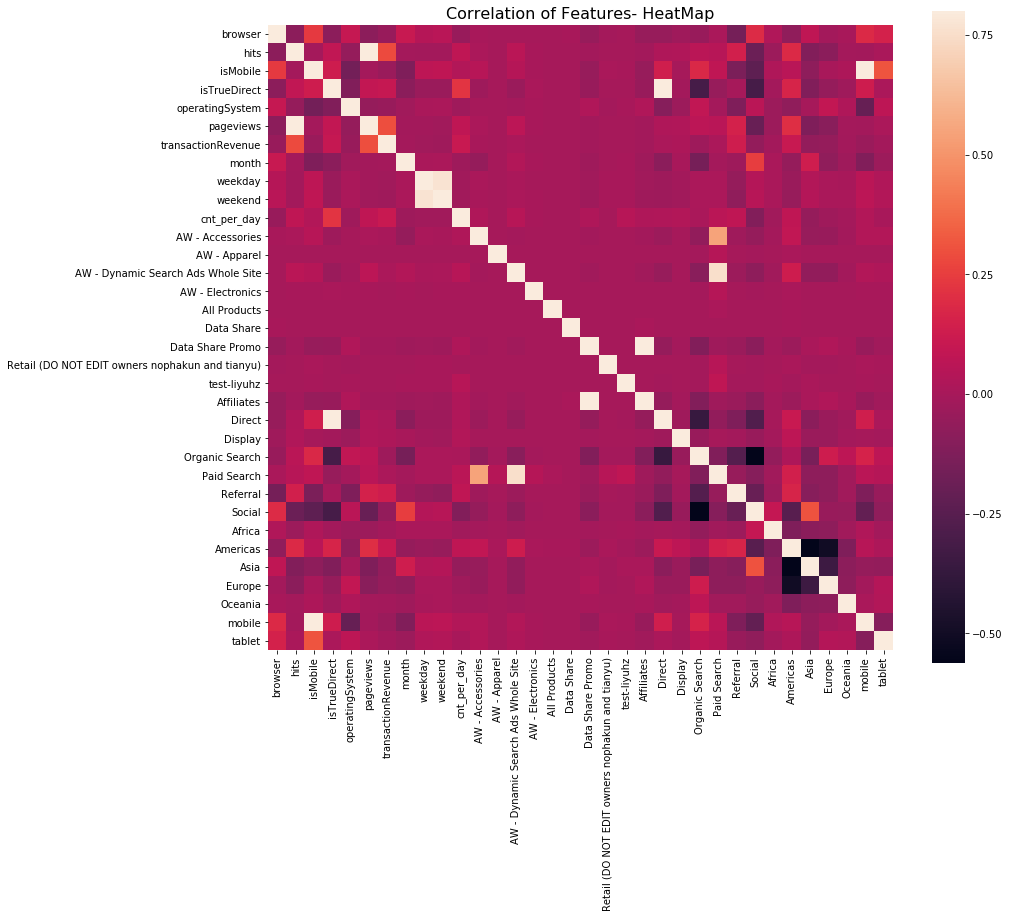

In [155]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

f , ax = plt.subplots(figsize = (14,12))
plt.title('Correlation of Features- HeatMap',y=1,size=16)
sns.heatmap(df_user_train.corr(),square = True,  vmax=0.8)
